# 4.3 Analysis and Discovery - Phase III
Reading Pulitzer Final data, i.e., after wrangling and first clean up id done. At this stage, I plan to do an in-depth analysis to find relationship and outliers.

In [1]:
import itertools
from multiprocessing import Pool
import sys
import time
from cassandra.cluster import Cluster
from cassandra.concurrent import execute_concurrent_with_args
from cassandra.query import tuple_factory
from cassandra.auth import PlainTextAuthProvider


import pandas as pd
from google.cloud import storage
import datetime as dt
from datetime import datetime
from pytz import timezone
import uuid

In [2]:
df_con=pd.read_csv('~/connection_point.csv',header=0) #connection headers
df_code=pd.read_csv('~/states_code.txt',header=0,sep='\t') #US State Dict
states_dict=dict(zip(df_code.Abbreviation,df_code.State)) #Creating the dict

### 4.3.1 Reading the Pulitzer Final Data from Cassandra

In [3]:
from IPython.display import display
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

def _fetchData(query_):
    cluster = Cluster(contact_points=[df_con.ip[0]], auth_provider = \
                      PlainTextAuthProvider(username=df_con.user[0], \
                                            password=df_con.token[0]))
    session = cluster.connect()
    session.set_keyspace('capstone')
    session.row_factory = pandas_factory    
    rows = session.execute(query_)
    return rows

if __name__ == "__main__":
    query_pram="SELECT  Newspaper,state,DailyCirculation_2004, \
                DailyCirculation_2013,ChangeDailyCirculation_2004_2013,\
                WinNFinalists_1990_2003,WinNFinalists_2004_2014,WinNFinalists_1990_2014, \
                GDP_2004,GDP_2013,GDP_2014,crimeindex,violentcrime_2004,\
                violentcrime_2013,violentcrime_2014,popestimate2004, \
                popestimate2013,popestimate2014 FROM capstone.pulitzerFinal"                                
    rows = _fetchData(query_pram)
    df_pulitzer=rows._current_rows 

### 4.3.2 Data Transformation

Performing basic data tranformation for analysis.

In [4]:
df_pulitzer.sample(7)

,newspaper,state,dailycirculation_2004,dailycirculation_2013,changedailycirculation_2004_2013,winnfinalists_1990_2003,winnfinalists_2004_2014,winnfinalists_1990_2014,gdp_2004,gdp_2013,gdp_2014,crimeindex,violentcrime_2004,violentcrime_2013,violentcrime_2014,popestimate2004,popestimate2013,popestimate2014
38,Louisville Courier-Journal,Kentucky,"216,934","131,208",-40%,0,3,3,135,181,185,1305,1360088,1168298,1165383,4413057.0,4219239.0,4256672.0
30,Chicago Sun-Times,Illinois,"453,757","470,548",4%,1,1,2,558,721,747,1616,1360088,1168298,1165383,12867544.0,12643955.0,12695866.0
12,Arizona Republic,Arizona,"466,926","293,640",-37%,5,2,7,204,270,280,2025,1360088,1168298,1165383,6719993.0,6029141.0,6167681.0
23,South Florida Sun-Sentinel,Florida,"268,297","163,728",-39%,0,1,1,639,794,832,2095,1360088,1168298,1165383,19888740.0,18166990.0,18367842.0
49,Kansas City Star,Kansas,"275,747","189,283",-31%,2,0,2,99,143,147,1670,1360088,1168298,1165383,2899360.0,2762931.0,2783785.0
47,Columbus Dispatch,Ohio,"259,127","137,148",-47%,1,0,1,451,564,591,1691,1360088,1168298,1165383,11594408.0,11481213.0,11500468.0
13,Baltimore Sun,Maryland,"277,947","177,054",-36%,11,2,13,246,339,350,1884,1360088,1168298,1165383,5967295.0,5627367.0,5653408.0


In [5]:
inv_map = {v: k for k, v in states_dict.items()}
df_pulitzer.state=df_pulitzer.state.apply(lambda x:inv_map[x])

df_pulitzer['dailycirculation_2013']=df_pulitzer.dailycirculation_2013.apply(lambda x: x.replace(',',''))
df_pulitzer['dailycirculation_2004']=df_pulitzer.dailycirculation_2004.apply(lambda x: x.replace(',',''))

df_pulitzer['dailycirculation_2013']=df_pulitzer.dailycirculation_2013.apply(lambda x: float(x))
df_pulitzer['dailycirculation_2004']=df_pulitzer.dailycirculation_2004.apply(lambda x: float(x))

df_pulitzer['winnfinalists_1990_2003']=df_pulitzer.winnfinalists_1990_2003.apply(lambda x: float(x))
df_pulitzer['winnfinalists_2004_2014']=df_pulitzer.winnfinalists_2004_2014.apply(lambda x: float(x))
df_pulitzer['winnfinalists_1990_2014']=df_pulitzer.winnfinalists_1990_2014.apply(lambda x: float(x))

df_pulitzer['gdp_2004']=df_pulitzer.gdp_2004.apply(lambda x: float(x))
df_pulitzer['gdp_2013']=df_pulitzer.gdp_2013.apply(lambda x: float(x))
df_pulitzer['gdp_2014']=df_pulitzer.gdp_2014.apply(lambda x: float(x))

df_pulitzer['crimeindex']=df_pulitzer.crimeindex.apply(lambda x: float(x))

df_pulitzer['violentcrime_2004']=df_pulitzer.violentcrime_2004.apply(lambda x: float(x))
df_pulitzer['violentcrime_2013']=df_pulitzer.violentcrime_2013.apply(lambda x: float(x))
df_pulitzer['violentcrime_2014']=df_pulitzer.violentcrime_2014.apply(lambda x: float(x))

df_pulitzer['popestimate2004']=df_pulitzer.popestimate2004.apply(lambda x: float(x))
df_pulitzer['popestimate2013']=df_pulitzer.popestimate2013.apply(lambda x: float(x))
df_pulitzer['popestimate2014']=df_pulitzer.popestimate2014.apply(lambda x: float(x))

In [6]:
df_pulitzer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 18 columns):
newspaper                           50 non-null object
state                               50 non-null object
dailycirculation_2004               50 non-null float64
dailycirculation_2013               50 non-null float64
changedailycirculation_2004_2013    50 non-null object
winnfinalists_1990_2003             50 non-null float64
winnfinalists_2004_2014             50 non-null float64
winnfinalists_1990_2014             50 non-null float64
gdp_2004                            50 non-null float64
gdp_2013                            50 non-null float64
gdp_2014                            50 non-null float64
crimeindex                          50 non-null float64
violentcrime_2004                   50 non-null float64
violentcrime_2013                   50 non-null float64
violentcrime_2014                   50 non-null float64
popestimate2004                     50 non-null float64
pope

In [7]:
df_pulitzer.sample(7)

,newspaper,state,dailycirculation_2004,dailycirculation_2013,changedailycirculation_2004_2013,winnfinalists_1990_2003,winnfinalists_2004_2014,winnfinalists_1990_2014,gdp_2004,gdp_2013,gdp_2014,crimeindex,violentcrime_2004,violentcrime_2013,violentcrime_2014,popestimate2004,popestimate2013,popestimate2014
21,Tampa Tribune,FL,238877.0,191477.0,-20%,0.0,0.0,0.0,639.0,794.0,832.0,2095.0,1360088.0,1168298.0,1165383.0,19888740.0,18166990.0,18367842.0
10,Washington Post,DC,760034.0,474767.0,-38%,52.0,48.0,100.0,79.0,111.0,116.0,3747.0,1360088.0,1168298.0,1165383.0,659005.0,570681.0,574404.0
18,Philadelphia Inquirer,PA,376454.0,306831.0,-18%,24.0,8.0,32.0,483.0,659.0,684.0,1335.0,1360088.0,1168298.0,1165383.0,12790565.0,12510809.0,12563937.0
15,Atlanta Journal Constitution,GA,409873.0,231094.0,-44%,1.0,5.0,6.0,364.0,454.0,477.0,1911.0,1360088.0,1168298.0,1165383.0,10087231.0,9155813.0,9349988.0
34,Rocky Mountain News,CO,340007.0,0.0,-100%,4.0,1.0,5.0,204.0,286.0,305.0,1526.0,1360088.0,1168298.0,1165383.0,5349648.0,4720423.0,4803868.0
39,Boston Herald,MA,236899.0,95929.0,-60%,0.0,0.0,0.0,330.0,442.0,459.0,1368.0,1360088.0,1168298.0,1165383.0,6749911.0,6410084.0,6431559.0
14,Orange County Register,CA,310001.0,356165.0,15%,3.0,2.0,5.0,1645.0,2223.0,2349.0,1701.0,1360088.0,1168298.0,1165383.0,38680808.0,36021200.0,36250312.0


### 4.3.3 Analysis

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

Let us find our the basic stats of Pulitzer data

In [137]:
df_pulitzer.sample(10)

,newspaper,state,dailycirculation_2004,dailycirculation_2013,changedailycirculation_2004_2013,winnfinalists_1990_2003,winnfinalists_2004_2014,winnfinalists_1990_2014,gdp_2004,gdp_2013,gdp_2014,crimeindex,violentcrime_2004,violentcrime_2013,violentcrime_2014,popestimate2004,popestimate2013,popestimate2014
44,Newsday,NY,553117.0,377744.0,-32%,12.0,6.0,18.0,958.0,1330.0,1391.0,1194.0,1360088.0,1168298.0,1165383.0,19718516.0,19104632.0,19132336.0
4,Detroit Free Press,MI,379304.0,209652.0,-45%,7.0,5.0,12.0,382.0,429.0,445.0,1757.0,1360088.0,1168298.0,1165383.0,9915767.0,10036081.0,10001284.0
32,Daily Oklahoman,OK,223403.0,124667.0,-44%,0.0,0.0,0.0,113.0,186.0,196.0,1938.0,1360088.0,1168298.0,1165383.0,3877499.0,3594090.0,3634349.0
0,Orlando Sentinel,FL,269269.0,161070.0,-40%,5.0,2.0,7.0,639.0,794.0,832.0,2095.0,1360088.0,1168298.0,1165383.0,19888740.0,18166990.0,18367842.0
16,Cleveland Plain Dealer,OH,367528.0,311605.0,-15%,4.0,7.0,11.0,451.0,564.0,591.0,1691.0,1360088.0,1168298.0,1165383.0,11594408.0,11481213.0,11500468.0
26,USA Today,VA,2192098.0,1674306.0,-24%,1.0,1.0,2.0,331.0,449.0,459.0,1125.0,1360088.0,1168298.0,1165383.0,8317372.0,7673725.0,7751000.0
11,Milwaukee Journal Sentinel,WI,241605.0,198469.0,-18%,2.0,8.0,10.0,215.0,281.0,290.0,1227.0,1360088.0,1168298.0,1165383.0,5758377.0,5577655.0,5610775.0
48,San Diego Union-Tribune,CA,355771.0,250678.0,-30%,0.0,2.0,2.0,1645.0,2223.0,2349.0,1701.0,1360088.0,1168298.0,1165383.0,38680808.0,36021200.0,36250312.0
38,Louisville Courier-Journal,KY,216934.0,131208.0,-40%,0.0,3.0,3.0,135.0,181.0,185.0,1305.0,1360088.0,1168298.0,1165383.0,4413057.0,4219239.0,4256672.0
3,Indianapolis Star,IN,253778.0,156850.0,-38%,1.0,0.0,1.0,238.0,311.0,324.0,1599.0,1360088.0,1168298.0,1165383.0,6595233.0,6332669.0,6379599.0


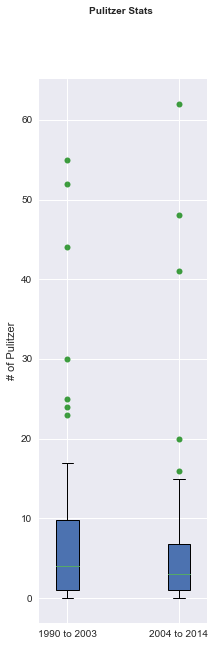

In [178]:
fig, axes = plt.subplots(figsize=(3, 10))
fig.suptitle('Pulitzer Stats', fontsize=10, fontweight='bold')
axes.set_ylabel('# of Pulitzer')

_ = axes.boxplot(
    [df_pulitzer.winnfinalists_1990_2003,df_pulitzer.winnfinalists_2004_2014], \
    positions = [1, 3], \
    labels = ['1990 to 2003','2004 to 2014'], \
    patch_artist = True, widths = 0.4,showfliers=True,sym='gx')

for flier in _['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=.75)
    
#fig, axes = plt.subplots(2,1, figsize=(3, 10))        
#bp=plt.boxplot(df_pulitzer.winnfinalists_1990_2003,widths=0.3,showfliers=True,  \
#               patch_artist=True,sym='b+',labels=['Pulitzer Price (1990 to 2003)'])

#for flier in bp['fliers']:
#    flier.set(marker='o', color='#e7298a', alpha=.75)
    
#print([item.get_ydata()[0] for item in _['whiskers']])
#print([item.get_ydata()[0] for item in _['medians']])
#print([item.get_ydata()[0] for item in _['caps']])
#axes.text(1.05, 7.25, '%.3f' % 6.75,  verticalalignment='center', fontsize=9)#, backgroundcolor="white")
plt.show()


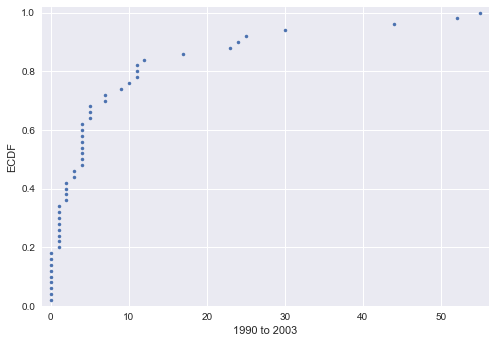

In [184]:
#Empirical Cumulative Distribution Function (ECDF)
import numpy as np
x=sorted(df_pulitzer.winnfinalists_1990_2003)
y=np.arange(1,len(x)+1)/len(x)
_=plt.plot(x,y,marker='.',linestyle='none')
_=plt.xlabel('1990 to 2003')
_=plt.ylabel('ECDF')
plt.margins(0.02)
plt.show()

#80% of the newpaper population is under 10 - 20% of population is above 10

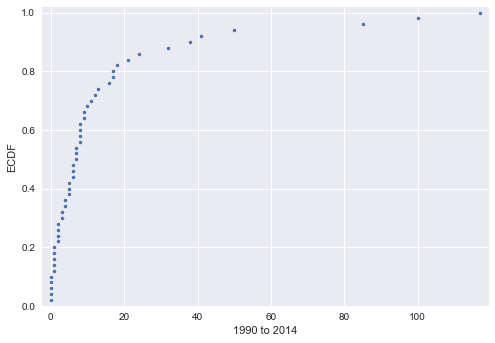

In [185]:
#Empirical Cumulative Distribution Function (ECDF)
import numpy as np
x=sorted(df_pulitzer.winnfinalists_1990_2014)
y=np.arange(1,len(x)+1)/len(x)
_=plt.plot(x,y,marker='.',linestyle='none')
_=plt.xlabel('1990 to 2014')
_=plt.ylabel('ECDF')
plt.margins(0.02)
plt.show()

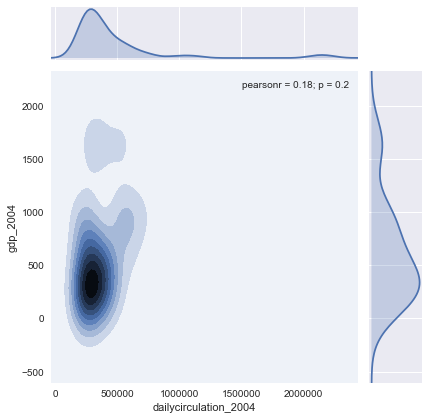

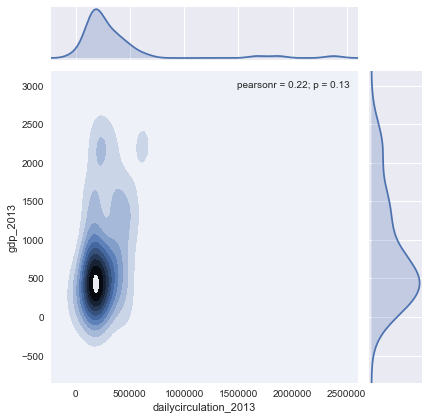

In [9]:
sns.jointplot(x='dailycirculation_2004',y='gdp_2004',data=df_pulitzer,kind='kde')
sns.jointplot(x='dailycirculation_2013',y='gdp_2013',data=df_pulitzer,kind='kde')
plt.show()

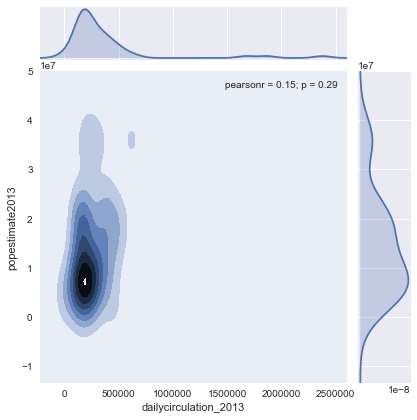

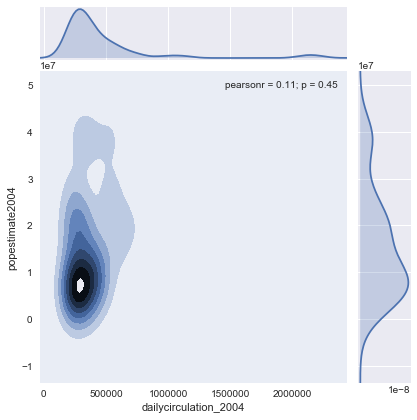

In [10]:
sns.jointplot(x='dailycirculation_2013',y='popestimate2013',data=df_pulitzer,kind='kde')
sns.jointplot(x='dailycirculation_2004',y='popestimate2004',data=df_pulitzer,kind='kde')
plt.show()

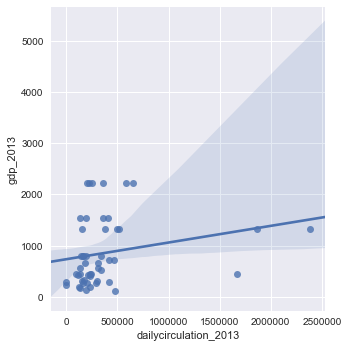

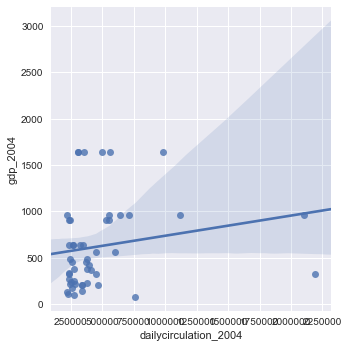

In [11]:
sns.lmplot(x='dailycirculation_2013',y='gdp_2013',data=df_pulitzer)
sns.lmplot(x='dailycirculation_2004',y='gdp_2004',data=df_pulitzer)
plt.show()

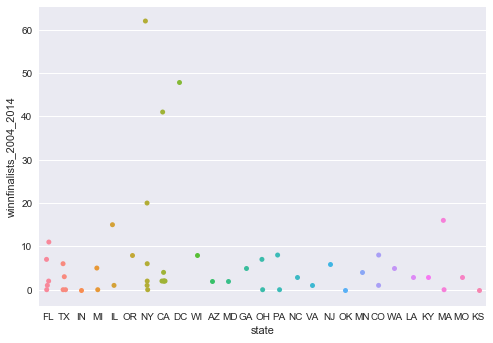

In [12]:
sns.stripplot(x='state',y='winnfinalists_2004_2014',data=df_pulitzer,jitter=True)
plt.show()

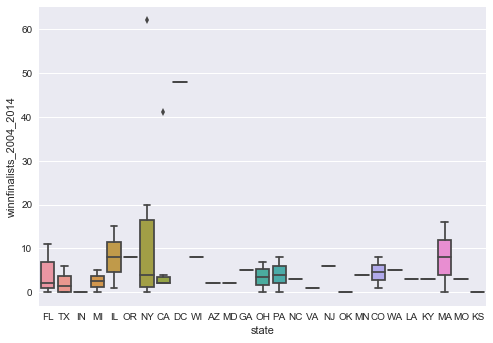

In [64]:
_=sns.boxplot(x='state',y='winnfinalists_2004_2014', \
            data=df_pulitzer)
plt.show()

In [45]:
df_pulitzer[(df_pulitzer.winnfinalists_2004_2014>=15)]

,newspaper,state,dailycirculation_2004,dailycirculation_2013,changedailycirculation_2004_2013,winnfinalists_1990_2003,winnfinalists_2004_2014,winnfinalists_1990_2014,gdp_2004,gdp_2013,gdp_2014,crimeindex,violentcrime_2004,violentcrime_2013,violentcrime_2014,popestimate2004,popestimate2013,popestimate2014
6,Chicago Tribune,IL,603315.0,414930.0,-31%,23.0,15.0,38.0,558.0,721.0,747.0,1616.0,1360088.0,1168298.0,1165383.0,12867544.0,12643955.0,12695866.0
10,Washington Post,DC,760034.0,474767.0,-38%,52.0,48.0,100.0,79.0,111.0,116.0,3747.0,1360088.0,1168298.0,1165383.0,659005.0,570681.0,574404.0
27,New York Times,NY,1119027.0,1865318.0,67%,55.0,62.0,117.0,958.0,1330.0,1391.0,1194.0,1360088.0,1168298.0,1165383.0,19718516.0,19104632.0,19132336.0
31,Wall Street Journal,NY,2101017.0,2378827.0,13%,30.0,20.0,50.0,958.0,1330.0,1391.0,1194.0,1360088.0,1168298.0,1165383.0,19718516.0,19104632.0,19132336.0
45,Los Angeles Times,CA,983727.0,653868.0,-34%,44.0,41.0,85.0,1645.0,2223.0,2349.0,1701.0,1360088.0,1168298.0,1165383.0,38680808.0,36021200.0,36250312.0
46,Boston Globe,MA,446241.0,245572.0,-45%,25.0,16.0,41.0,330.0,442.0,459.0,1368.0,1360088.0,1168298.0,1165383.0,6749911.0,6410084.0,6431559.0


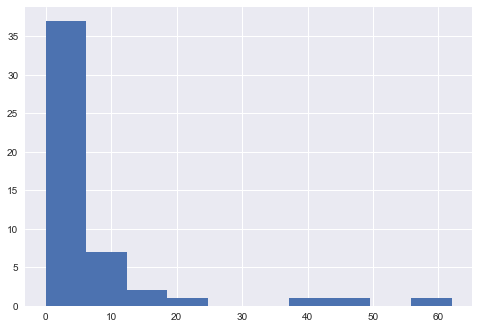

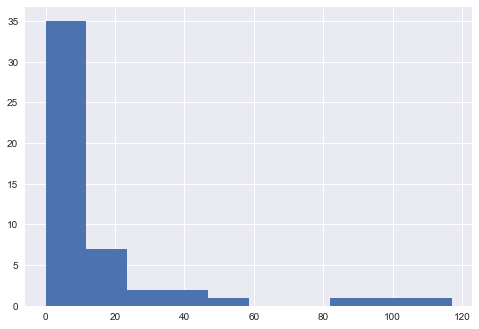

In [48]:
sns.set()
_=plt.hist(df_pulitzer['winnfinalists_2004_2014'])
plt.show()
_=plt.hist(df_pulitzer['winnfinalists_1990_2014'])
plt.show()

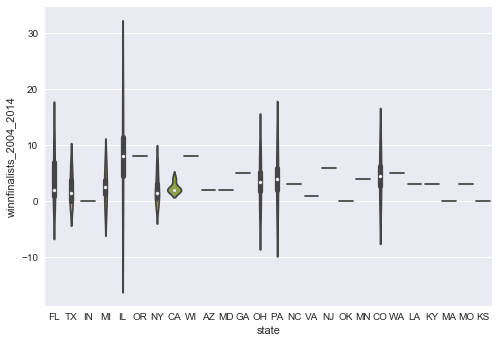

In [20]:
sns.violinplot(x='state',y='winnfinalists_2004_2014',data=df_pulitzer[df_pulitzer.winnfinalists_2004_2014<=15])

#sns.boxplot(x='state',y='winnfinalists_2004_2014', \
#            data=df_pulitzer[(df_pulitzer.winnfinalists_2004_2014<=15) & (df_pulitzer.state!=['CA','NY','DC'])])
plt.show()

In [50]:
df_pulitzer

,newspaper,state,dailycirculation_2004,dailycirculation_2013,changedailycirculation_2004_2013,winnfinalists_1990_2003,winnfinalists_2004_2014,winnfinalists_1990_2014,gdp_2004,gdp_2013,gdp_2014,crimeindex,violentcrime_2004,violentcrime_2013,violentcrime_2014,popestimate2004,popestimate2013,popestimate2014
0,Orlando Sentinel,FL,269269.0,161070.0,-40%,5.0,2.0,7.0,639.0,794.0,832.0,2095.0,1360088.0,1168298.0,1165383.0,19888740.0,18166990.0,18367842.0
1,Dallas Morning News,TX,528379.0,409265.0,-23%,11.0,6.0,17.0,909.0,1536.0,1614.0,1962.0,1360088.0,1168298.0,1165383.0,26944752.0,23359580.0,23831984.0
2,Houston Chronicle,TX,549300.0,360251.0,-34%,2.0,3.0,5.0,909.0,1536.0,1614.0,1962.0,1360088.0,1168298.0,1165383.0,26944752.0,23359580.0,23831984.0
3,Indianapolis Star,IN,253778.0,156850.0,-38%,1.0,0.0,1.0,238.0,311.0,324.0,1599.0,1360088.0,1168298.0,1165383.0,6595233.0,6332669.0,6379599.0
4,Detroit Free Press,MI,379304.0,209652.0,-45%,7.0,5.0,12.0,382.0,429.0,445.0,1757.0,1360088.0,1168298.0,1165383.0,9915767.0,10036081.0,10001284.0
5,Fort Woth Star-Telegram,TX,237318.0,188593.0,-21%,1.0,0.0,1.0,909.0,1536.0,1614.0,1962.0,1360088.0,1168298.0,1165383.0,26944752.0,23359580.0,23831984.0
6,Chicago Tribune,IL,603315.0,414930.0,-31%,23.0,15.0,38.0,558.0,721.0,747.0,1616.0,1360088.0,1168298.0,1165383.0,12867544.0,12643955.0,12695866.0
7,Oregonian,OR,339169.0,228909.0,-33%,9.0,8.0,17.0,142.0,196.0,203.0,1497.0,1360088.0,1168298.0,1165383.0,3968371.0,3670883.0,3722417.0
8,New York Post,NY,642844.0,500521.0,-22%,0.0,0.0,0.0,958.0,1330.0,1391.0,1194.0,1360088.0,1168298.0,1165383.0,19718516.0,19104632.0,19132336.0
9,Sacramento Bee,CA,303841.0,200802.0,-34%,4.0,4.0,8.0,1645.0,2223.0,2349.0,1701.0,1360088.0,1168298.0,1165383.0,38680808.0,36021200.0,36250312.0


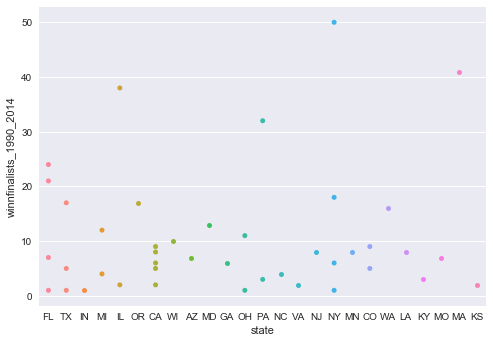

In [56]:
_=sns.swarmplot(x='state',y='winnfinalists_1990_2014',data=df_pulitzer[(df_pulitzer.winnfinalists_1990_2014>0) \
                                                                       & (df_pulitzer.winnfinalists_1990_2014<60)])
plt.show()

In [59]:
n=len(df_pulitzer[(df_pulitzer.winnfinalists_1990_2014>0) & (df_pulitzer.winnfinalists_1990_2014<60)])

In [60]:
df_pulitzer

,newspaper,state,dailycirculation_2004,dailycirculation_2013,changedailycirculation_2004_2013,winnfinalists_1990_2003,winnfinalists_2004_2014,winnfinalists_1990_2014,gdp_2004,gdp_2013,gdp_2014,crimeindex,violentcrime_2004,violentcrime_2013,violentcrime_2014,popestimate2004,popestimate2013,popestimate2014
0,Orlando Sentinel,FL,269269.0,161070.0,-40%,5.0,2.0,7.0,639.0,794.0,832.0,2095.0,1360088.0,1168298.0,1165383.0,19888740.0,18166990.0,18367842.0
1,Dallas Morning News,TX,528379.0,409265.0,-23%,11.0,6.0,17.0,909.0,1536.0,1614.0,1962.0,1360088.0,1168298.0,1165383.0,26944752.0,23359580.0,23831984.0
2,Houston Chronicle,TX,549300.0,360251.0,-34%,2.0,3.0,5.0,909.0,1536.0,1614.0,1962.0,1360088.0,1168298.0,1165383.0,26944752.0,23359580.0,23831984.0
3,Indianapolis Star,IN,253778.0,156850.0,-38%,1.0,0.0,1.0,238.0,311.0,324.0,1599.0,1360088.0,1168298.0,1165383.0,6595233.0,6332669.0,6379599.0
4,Detroit Free Press,MI,379304.0,209652.0,-45%,7.0,5.0,12.0,382.0,429.0,445.0,1757.0,1360088.0,1168298.0,1165383.0,9915767.0,10036081.0,10001284.0
5,Fort Woth Star-Telegram,TX,237318.0,188593.0,-21%,1.0,0.0,1.0,909.0,1536.0,1614.0,1962.0,1360088.0,1168298.0,1165383.0,26944752.0,23359580.0,23831984.0
6,Chicago Tribune,IL,603315.0,414930.0,-31%,23.0,15.0,38.0,558.0,721.0,747.0,1616.0,1360088.0,1168298.0,1165383.0,12867544.0,12643955.0,12695866.0
7,Oregonian,OR,339169.0,228909.0,-33%,9.0,8.0,17.0,142.0,196.0,203.0,1497.0,1360088.0,1168298.0,1165383.0,3968371.0,3670883.0,3722417.0
8,New York Post,NY,642844.0,500521.0,-22%,0.0,0.0,0.0,958.0,1330.0,1391.0,1194.0,1360088.0,1168298.0,1165383.0,19718516.0,19104632.0,19132336.0
9,Sacramento Bee,CA,303841.0,200802.0,-34%,4.0,4.0,8.0,1645.0,2223.0,2349.0,1701.0,1360088.0,1168298.0,1165383.0,38680808.0,36021200.0,36250312.0
